In [91]:
import boto3
import gzip
from io import BytesIO
import os

s3 = boto3.client('s3')
bucket_name = "mas-thesis-datapipeline-platform"
dp_kedro_logs_prefix = "logs/344f901d-f3d6-41a5-baa0-904d5c856af8/"
dp_plain_python_logs_prefix = "logs/0e42fb1c-24fa-4520-860b-a33919601ab6/"
local_kedro_directory = ".\\dp-kedro-logs"
local_plain_python_directory = ".\\dp-plain-python-logs"

def download_files(bucket_name, prefix, local_directory):
    paginator = s3.get_paginator('list_objects_v2')

    for page in paginator.paginate(Bucket=bucket_name, Prefix=prefix):
        for obj in page['Contents']:
            file_key = obj['Key']
            file_object = s3.get_object(Bucket=bucket_name, Key=file_key)
            file_content = file_object['Body'].read()

            with gzip.open(BytesIO(file_content), 'rt') as f:
                decompressed_content = f.read()

            local_filename = os.path.join(local_directory, file_key.split('/')[-2])
            print(f"Saving to {local_filename}")
            with open(local_filename, 'w') as f:
                f.write(decompressed_content)

# Download Kedro Files
os.makedirs(local_kedro_directory, exist_ok=True)
download_files(bucket_name, dp_kedro_logs_prefix, local_kedro_directory)

# Download plain python files
os.makedirs(local_plain_python_directory, exist_ok=True)
download_files(bucket_name, dp_plain_python_logs_prefix, local_plain_python_directory)

Saving to .\dp-kedro-logs\ecs-dp-kedro-013f5a9790014373939585051409cfa1
Saving to .\dp-kedro-logs\ecs-dp-kedro-084b41dd7fd241bf830fa0d843ed406f
Saving to .\dp-kedro-logs\ecs-dp-kedro-1cdc0b94baf9411896c7101f9a1b6d43
Saving to .\dp-kedro-logs\ecs-dp-kedro-2bef57e5c72e4580bf2a16a576860461
Saving to .\dp-kedro-logs\ecs-dp-kedro-353522b842f046ff8299738b5f3a67ce
Saving to .\dp-kedro-logs\ecs-dp-kedro-3eb28560905e4a528baa4b2e9c251063
Saving to .\dp-kedro-logs\ecs-dp-kedro-42418e73fb3e4129b3773f051995e4a5
Saving to .\dp-kedro-logs\ecs-dp-kedro-46e042b74a5841e0ad36e63668f3c555
Saving to .\dp-kedro-logs\ecs-dp-kedro-4f10541ff70d415dbb43ed41f372ba4a
Saving to .\dp-kedro-logs\ecs-dp-kedro-673969919fe540b6867692a6bcb04ec0
Saving to .\dp-kedro-logs\ecs-dp-kedro-77fdd80392174ad8a6586b11c324ac5a
Saving to .\dp-kedro-logs\ecs-dp-kedro-833237256e9445f8adf1c138e0be2c5f
Saving to .\dp-kedro-logs\ecs-dp-kedro-8f60049f94384452902136ff556a8efc
Saving to .\dp-kedro-logs\ecs-dp-kedro-9663ddf78dea4524b8227bec1

In [51]:
import re
from datetime import datetime
    
def extract_datetime(log_line):
    date_string = log_line[0:23]
    return datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%f')

def get_pipeline_start_timestamp(log_data):
    # Find the first timestamp in the log file (on line 1)
    start_time = extract_datetime(log_data[0])
    return start_time

def get_pipeline_end_timestamp(log_data):
    # Find the last timestamp in the log file (on last line)
    end_time = extract_datetime(log_data[-1])
    return end_time

def get_timestamp_by_message(log_data, message):
    completed_time = None

    for line in log_data:
        if message in line:
            completed_time = extract_datetime(line)
            return completed_time    

with open(local_kedro_directory + "/ecs-dp-kedro-fceb3a22958f47198511deb3cbf34c00", 'r') as file:
    log_data = file.readlines()

    start_time = get_timestamp_by_message(log_data, "Kedro project kedro_docker")
    transform_start_time = get_timestamp_by_message(log_data, "Running node: preprocess_feature_set")
    analysis_start_time = get_timestamp_by_message(log_data, "Running node: split_data_node")
    end_time = get_timestamp_by_message(log_data, "Pipeline execution completed")

print(f"Start time: {start_time}")
print(f"End time: {end_time}")
print(f"Transform Start: {transform_start_time}")
print(f"Analysis Start: {end_time}")

with open(local_plain_python_directory + "/ecs-dp-plain-python-1acc371a09604375b430325e3d20502e", 'r') as file:
    log_data = file.readlines()

    start_time = get_timestamp_by_message(log_data, "Data Pipeline started.")
    transform_start_time = get_timestamp_by_message(log_data, "Running node: preprocess_feature_set")
    analysis_start_time = get_timestamp_by_message(log_data, "Starting Transformation Step for analytics")
    end_time = get_timestamp_by_message(log_data, "Data Pipeline completed")

print("")
print(f"Start time: {start_time}")
print(f"End time: {end_time}")
print(f"Transform Start: {transform_start_time}")
print(f"Analysis Start: {end_time}")

Start time: 2023-06-18 09:20:31.528000
End time: 2023-06-18 09:21:47.418000
Transform Start: 2023-06-18 09:20:43.815000
Analysis Start: 2023-06-18 09:21:47.418000

Start time: 2023-06-22 03:03:43.134000
End time: 2023-06-22 03:04:42.359000
Transform Start: None
Analysis Start: 2023-06-22 03:04:42.359000


In [52]:
import pandas as pd
from pathlib import Path

def extract_kedro_log_data(filepath):
    with open(filepath, 'r') as file:
        log_data = file.readlines()

    start_time = get_timestamp_by_message(log_data, "Kedro project kedro_docker")
    transform_start_time = get_timestamp_by_message(log_data, "Running node: preprocess_feature_set")
    analysis_start_time = get_timestamp_by_message(log_data, "Running node: split_data_node")
    end_time = get_timestamp_by_message(log_data, "Pipeline execution completed")
    
    data = {
        'log_file': Path(filepath).name,
        'Start Time': [start_time],
        'End Time': [end_time],
        'Transform Start Time': [transform_start_time],
        'Analysis Start Time': [analysis_start_time],
        'Total Runtime': [end_time - start_time],
        'Extract Load Runtime': [transform_start_time - start_time],
        'Transform Runtime': [analysis_start_time - transform_start_time],
        'Analytics Runtime': [end_time - analysis_start_time],
        'Total Runtime Seconds': [(end_time - start_time).total_seconds()],
        'Extract Load Runtime Seconds': [(transform_start_time - start_time).total_seconds()],
        'Transform Runtime Seconds': [(analysis_start_time - transform_start_time).total_seconds()],
        'Analytics Runtime Seconds': [(end_time - analysis_start_time).total_seconds()],
    }
    
    return pd.DataFrame(data)

kedro_data = pd.DataFrame()

for filename in os.listdir(local_kedro_directory):
    filepath = os.path.join(local_kedro_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_kedro_log_data(filepath)
        kedro_data = pd.concat([kedro_data, file_data], ignore_index=True)

print(kedro_data)
kedro_data.to_csv('.\\kedro_measurements.csv', index=False)

                                         log_file              Start Time  \
0   ecs-dp-kedro-013f5a9790014373939585051409cfa1 2023-06-18 08:18:18.069   
1   ecs-dp-kedro-084b41dd7fd241bf830fa0d843ed406f 2023-06-21 12:06:22.324   
2   ecs-dp-kedro-1cdc0b94baf9411896c7101f9a1b6d43 2023-06-17 12:31:47.666   
3   ecs-dp-kedro-2bef57e5c72e4580bf2a16a576860461 2023-06-18 09:26:59.168   
4   ecs-dp-kedro-353522b842f046ff8299738b5f3a67ce 2023-06-17 06:32:42.958   
5   ecs-dp-kedro-3eb28560905e4a528baa4b2e9c251063 2023-06-20 11:23:02.691   
6   ecs-dp-kedro-42418e73fb3e4129b3773f051995e4a5 2023-06-17 06:17:27.625   
7   ecs-dp-kedro-46e042b74a5841e0ad36e63668f3c555 2023-06-20 11:27:29.889   
8   ecs-dp-kedro-4f10541ff70d415dbb43ed41f372ba4a 2023-06-17 09:26:05.882   
9   ecs-dp-kedro-673969919fe540b6867692a6bcb04ec0 2023-06-17 08:40:38.850   
10  ecs-dp-kedro-77fdd80392174ad8a6586b11c324ac5a 2023-06-19 08:39:27.097   
11  ecs-dp-kedro-833237256e9445f8adf1c138e0be2c5f 2023-06-22 03:03:25.720   

In [53]:

def extract_plain_python_log_data(filepath):
    with open(filepath, 'r') as file:
        log_data = file.readlines()

    start_time = get_timestamp_by_message(log_data, "Data Pipeline started.")
    transform_start_time = get_timestamp_by_message(log_data, "Starting Transformation Step for analytics")
    analysis_start_time = get_timestamp_by_message(log_data, "Starting Analytics Step")
    end_time = get_timestamp_by_message(log_data, "Data Pipeline completed")
    
    data = {
        'log_file': Path(filepath).name,
        'Start Time': [start_time],
        'End Time': [end_time],
        'Transform Start Time': [transform_start_time],
        'Analysis Start Time': [analysis_start_time],
        'Total Runtime': [end_time - start_time],
        'Extract Load Runtime': [transform_start_time - start_time],
        'Transform Runtime': [analysis_start_time - transform_start_time],
        'Analytics Runtime': [end_time - analysis_start_time],
        'Total Runtime Seconds': [(end_time - start_time).total_seconds()],
        'Extract Load Runtime Seconds': [(transform_start_time - start_time).total_seconds()],
        'Transform Runtime Seconds': [(analysis_start_time - transform_start_time).total_seconds()],
        'Analytics Runtime Seconds': [(end_time - analysis_start_time).total_seconds()],
    }
    
    return pd.DataFrame(data)

plain_python_data = pd.DataFrame()

for filename in os.listdir(local_plain_python_directory):
    filepath = os.path.join(local_plain_python_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_plain_python_log_data(filepath)
        plain_python_data = pd.concat([plain_python_data, file_data], ignore_index=True)

print(plain_python_data)
plain_python_data.to_csv('.\\plain_python_measurements.csv', index=False)

                                             log_file              Start Time  \
0   ecs-dp-plain-python-1acc371a09604375b430325e3d... 2023-06-22 03:03:43.134   
1   ecs-dp-plain-python-231fe9ef90b1487a8214fd361b... 2023-06-18 09:29:56.439   
2   ecs-dp-plain-python-336851e7eea44b08960c2b4599... 2023-06-18 09:34:54.282   
3   ecs-dp-plain-python-37341893fb3e469eb9243f52b1... 2023-06-18 08:18:45.193   
4   ecs-dp-plain-python-39b1406318974844af1df03429... 2023-06-21 11:18:44.988   
5   ecs-dp-plain-python-52c28146a4c741b7b8cabff680... 2023-06-20 11:48:10.436   
6   ecs-dp-plain-python-6623ab0d3c0b41a69d2de93e1d... 2023-06-21 12:19:03.593   
7   ecs-dp-plain-python-693fac967e4540b490430f4d64... 2023-06-21 12:06:43.940   
8   ecs-dp-plain-python-85112b1c7b144b27bdbe052eb6... 2023-06-20 11:23:25.631   
9   ecs-dp-plain-python-8c1f345ae2eb43e985edc0fe3a... 2023-06-17 06:32:54.140   
10  ecs-dp-plain-python-91725692659145da87c7058c90... 2023-06-18 09:23:41.635   
11  ecs-dp-plain-python-a10d

In [54]:
import json
from objectpath import Tree

local_lambda_directory = Path(".\\dp-lambda-logs")

def find_timestamp_in_stepfunctions(data, type_value, step_name = None):
    tree_obj = Tree(data)
    
    if step_name:
        result_set = tree_obj.execute(f"$.historyHash..*[@.type is '{type_value}' and @.stepName is '{step_name}'].timestamp")
    else:
        result_set = tree_obj.execute(f"$.historyHash..*[@.type is '{type_value}'].timestamp")
    result_list = list(result_set)
    
    if(len(result_list) == 0):
        raise Exception(
            f"No entry found with type {type_value}" + (f" and stepName {step_name}" if step_name else "")
        )
    if(len(result_list) > 1):
        raise Exception(
            f"MULTIPLE entries found with type {type_value}" + (f" and stepName {step_name}" if step_name else "")
        )
    
    return result_list[0]

with open(local_lambda_directory / '0a49640f-caea-4b96-9c87-0904de40aa7c.json') as json_file:
    data = json.load(json_file)
    
    start_time = find_timestamp_in_stepfunctions(data, "ExecutionStarted")
    transform_start_time = find_timestamp_in_stepfunctions(data, "ParallelStateEntered", "Parallel (1)")
    analysis_start_time = find_timestamp_in_stepfunctions(data, "TaskStateEntered", "Run Analytics")
    end_time = find_timestamp_in_stepfunctions(data, "ExecutionSucceeded")

print(f"Start time: {start_time}")
print(f"Transform Start: {transform_start_time}")
print(f"Analysis Start: {analysis_start_time}")
print(f"End time: {end_time}")

Start time: 1686993945237
Transform Start: 1686993958252
Analysis Start: 1686993980230
End time: 1686994039652


In [82]:
def to_datetime(timestamp):
    unix_timestamp_seconds = timestamp / 1000
    return datetime.fromtimestamp(unix_timestamp_seconds)

def extract_lambda_log_data(filepath):
    with open(filepath) as json_file:
        data = json.load(json_file)
    
    start_time = to_datetime(find_timestamp_in_stepfunctions(data, "ExecutionStarted"))
    transform_start_time = to_datetime(find_timestamp_in_stepfunctions(data, "ParallelStateEntered", "Parallel (1)"))
    analysis_start_time = to_datetime(find_timestamp_in_stepfunctions(data, "TaskStateEntered", "Run Analytics"))
    
    try:
        end_time = to_datetime(find_timestamp_in_stepfunctions(data, "ExecutionSucceeded"))
    except:
        # For failed pipeline scenario
        end_time = to_datetime(find_timestamp_in_stepfunctions(data, "ExecutionFailed"))
    
    data = {
        'log_file': Path(filepath).name,
        'Start Time': [start_time],
        'End Time': [end_time],
        'Transform Start Time': [transform_start_time],
        'Analysis Start Time': [analysis_start_time],
        'Total Runtime': [end_time - start_time],
        'Extract Load Runtime': [transform_start_time - start_time],
        'Transform Runtime': [analysis_start_time - transform_start_time],
        'Analytics Runtime': [end_time - analysis_start_time],
        'Total Runtime Seconds': [(end_time - start_time).total_seconds()],
        'Extract Load Runtime Seconds': [(transform_start_time - start_time).total_seconds()],
        'Transform Runtime Seconds': [(analysis_start_time - transform_start_time).total_seconds()],
        'Analytics Runtime Seconds': [(end_time - analysis_start_time).total_seconds()],
    }
    
    return pd.DataFrame(data)

lambda_data = pd.DataFrame()

for filename in os.listdir(local_lambda_directory):
    filepath = os.path.join(local_lambda_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_lambda_log_data(filepath)
        lambda_data = pd.concat([lambda_data, file_data], ignore_index=True)

print(lambda_data)
lambda_data.to_csv('.\\lambda_measurements.csv', index=False)

                                     log_file              Start Time  \
0   01c8fa2f-13fe-4bb3-b572-5d0ce89309a4.json 2023-06-17 17:56:32.952   
1   0a49640f-caea-4b96-9c87-0904de40aa7c.json 2023-06-17 17:25:45.237   
2   14ed07fe-1408-44c0-a20a-452051d8b4e3.json 2023-06-17 14:32:24.525   
3   21fabe08-b29b-4eca-b913-15ff1b199fdd.json 2023-06-19 16:38:38.736   
4   2c9959a2-aa88-412c-ad66-9beaf6b0ba74.json 2023-06-20 19:22:36.385   
5   37a9d913-bab3-41f2-8176-5580518fa0f3.json 2023-06-17 16:40:04.522   
6   38e2e7d7-a832-452b-bf3f-c4ad821a2e65.json 2023-06-17 13:17:17.445   
7   64200c15-d1d9-41ed-af2a-bb0ec27eb959.json 2023-06-22 10:53:46.939   
8   78163d4c-61e4-410e-b70a-a9d85a8fec7c.json 2023-06-17 13:13:25.004   
9   7b0e3387-a02c-4872-900c-0815b6a29715.json 2023-06-18 17:22:34.865   
10  7d738f72-ad46-4639-9ad2-f8041064c5f9.json 2023-06-20 19:47:24.285   
11  820dd48e-a267-49fd-ba13-dcc8902a3b17.json 2023-06-20 19:26:46.723   
12  867f3469-6193-408b-b07d-f2e5a2887322.json 2023-

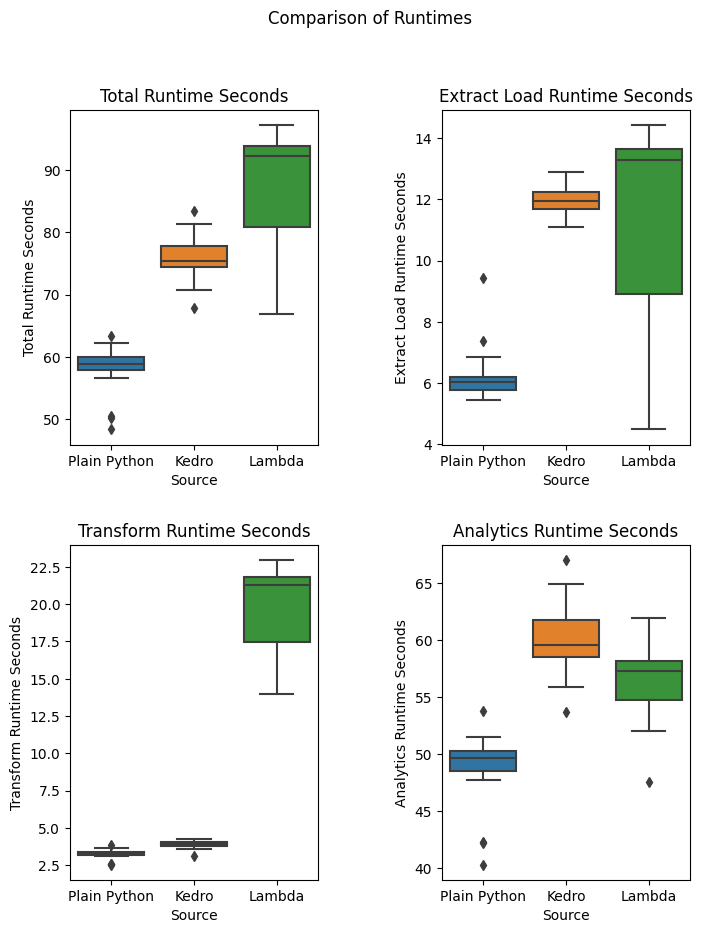

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

plain_python_data['Source'] = 'Plain Python'
kedro_data['Source'] = 'Kedro'
lambda_data['Source'] = 'Lambda'

combined_df = pd.concat([plain_python_data, kedro_data, lambda_data])
columns_to_plot = [
    'Total Runtime Seconds',
    'Extract Load Runtime Seconds',
    'Transform Runtime Seconds',
    'Analytics Runtime Seconds',
    ]


fig, axs = plt.subplots(2, 2, figsize=(8, 10))
plt.subplots_adjust(wspace=.5, hspace=.3)

for i, column in enumerate(columns_to_plot):
    # Determine subplot
    ax = axs[i//2, i%2]

    # Draw the boxplot on each subplot
    sns.boxplot(data=combined_df, x='Source', y=column, ax=ax)

    # Set title for each subplot
    ax.set_title(column)

    
plt.suptitle("Comparison of Runtimes")


plt.show()


In [92]:
dp_kedro_logs_big_prefix = "logs/82bcf638-fa4a-4576-9782-04dea45f5345/"
dp_plain_python_logs_big_prefix = "logs/aba60f8e-2cfe-4510-84e7-e411239b410c/"

local_kedro_big_directory = ".\\dp-kedro-logs-big"
local_plain_python_big_directory = ".\\dp-plain-python-logs-big"

# Download Kedro Files
os.makedirs(local_kedro_big_directory, exist_ok=True)
download_files(bucket_name, dp_kedro_logs_big_prefix, local_kedro_big_directory)

# Download plain python files
os.makedirs(local_plain_python_big_directory, exist_ok=True)
download_files(bucket_name, dp_plain_python_logs_big_prefix, local_plain_python_big_directory)

Saving to .\dp-kedro-logs-big\ecs-dp-kedro-1eaacadaf41d47f4880a39fa1a1d6b61
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-27fd6c400e3a486498eaabaaa2c31586
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-2ca68d49fa40404fbbb30401a23fe560
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-306e9190b31e4ed0a11eddb562eb97df
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-6326d55434ad4556904e855d52019068
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-664a2356f4df4f6e847deb58a4161955
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-b91fa27c32b84684a7faffbf317de3b2
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-bd4107d5e47b45c9be9df4d788679860
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-c1a5b8915db240adbe4f65de852f40d6
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-c67847e1e0144d939721420a83ff6feb
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-cdc8fe84d60147ed8a5950f647d2e0d0
Saving to .\dp-kedro-logs-big\ecs-dp-kedro-e0223e7d914d4f1bb022b1df0628e5a4
Saving to .\dp-plain-python-logs-big\ecs-dp-plain-python-008798a0d4d841989786c6bff9b8e74

In [94]:
plain_python_big_data = pd.DataFrame()

for filename in os.listdir(local_plain_python_big_directory):
    filepath = os.path.join(local_plain_python_big_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_plain_python_log_data(filepath)
        plain_python_big_data = pd.concat([plain_python_big_data, file_data], ignore_index=True)

print(plain_python_big_data)
plain_python_big_data.to_csv('.\\plain_python_big_measurements.csv', index=False)

                                             log_file              Start Time  \
0   ecs-dp-plain-python-008798a0d4d841989786c6bff9... 2023-06-24 09:29:13.770   
1   ecs-dp-plain-python-116a520c236a43ee972f188a43... 2023-06-25 03:32:40.368   
2   ecs-dp-plain-python-2ddc861965d24759a0bb51c49e... 2023-06-24 08:04:28.823   
3   ecs-dp-plain-python-85985cad209b4efea39f35c1ed... 2023-06-24 08:46:25.555   
4   ecs-dp-plain-python-a59a7ac5d4ea4c41b033d5f4f9... 2023-06-24 09:40:57.302   
5   ecs-dp-plain-python-a7e85889f5044d3da14c316e4d... 2023-06-24 11:27:45.099   
6   ecs-dp-plain-python-bf97e55adab140dfac14ba02ce... 2023-06-24 08:17:08.725   
7   ecs-dp-plain-python-d3a9948ce6084165b7d466277e... 2023-06-24 08:25:56.224   
8   ecs-dp-plain-python-df2674e7b4b64294ab61bb944c... 2023-06-24 08:53:05.108   
9   ecs-dp-plain-python-ef81b9dfd94242d89294d3a6a9... 2023-06-24 08:10:57.068   
10  ecs-dp-plain-python-f08633c1100c4ec1b1302d3f8e... 2023-06-24 09:22:35.553   

                  End Time 

In [95]:
kedro_big_data = pd.DataFrame()

for filename in os.listdir(local_kedro_big_directory):
    filepath = os.path.join(local_kedro_big_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_kedro_log_data(filepath)
        kedro_big_data = pd.concat([kedro_big_data, file_data], ignore_index=True)

print(kedro_big_data)
kedro_big_data.to_csv('.\\kedro_big_measurements.csv', index=False)

.\dp-kedro-logs-big\ecs-dp-kedro-1eaacadaf41d47f4880a39fa1a1d6b61
.\dp-kedro-logs-big\ecs-dp-kedro-27fd6c400e3a486498eaabaaa2c31586
.\dp-kedro-logs-big\ecs-dp-kedro-2ca68d49fa40404fbbb30401a23fe560
.\dp-kedro-logs-big\ecs-dp-kedro-306e9190b31e4ed0a11eddb562eb97df
.\dp-kedro-logs-big\ecs-dp-kedro-6326d55434ad4556904e855d52019068
.\dp-kedro-logs-big\ecs-dp-kedro-664a2356f4df4f6e847deb58a4161955
.\dp-kedro-logs-big\ecs-dp-kedro-b91fa27c32b84684a7faffbf317de3b2
.\dp-kedro-logs-big\ecs-dp-kedro-bd4107d5e47b45c9be9df4d788679860
.\dp-kedro-logs-big\ecs-dp-kedro-c1a5b8915db240adbe4f65de852f40d6
.\dp-kedro-logs-big\ecs-dp-kedro-c67847e1e0144d939721420a83ff6feb
.\dp-kedro-logs-big\ecs-dp-kedro-cdc8fe84d60147ed8a5950f647d2e0d0
.\dp-kedro-logs-big\ecs-dp-kedro-e0223e7d914d4f1bb022b1df0628e5a4
                                         log_file              Start Time  \
0   ecs-dp-kedro-1eaacadaf41d47f4880a39fa1a1d6b61 2023-06-24 09:40:28.788   
1   ecs-dp-kedro-27fd6c400e3a486498eaabaaa2c31586 2023

In [96]:
local_lambda_big_directory = ".\\dp-lambda-logs-big"

lambda_big_data = pd.DataFrame()

for filename in os.listdir(local_lambda_big_directory):
    filepath = os.path.join(local_lambda_big_directory, filename)
    
    if os.path.isfile(filepath):
        file_data = extract_lambda_log_data(filepath)
        lambda_big_data = pd.concat([lambda_big_data, file_data], ignore_index=True)

print(lambda_big_data)
lambda_big_data.to_csv('.\\lambda_big_measurements.csv', index=False)

                                    log_file              Start Time  \
0  2f6d9503-8160-47e9-bb1c-c95887e35c2e.json 2023-06-24 19:34:49.953   
1  344cc4a3-991f-4099-95f3-8df9aca348d2.json 2023-06-24 18:01:52.993   
2  4c376275-1a80-4e8e-8a1a-229af149019d.json 2023-06-24 17:45:25.263   
3  50b9e89a-afe1-411e-bc26-2eaeeeb015fe.json 2023-06-24 19:26:34.547   
4  79da2511-0f0f-f9bd-1d30-f59bc734138d.json 2023-06-24 17:20:58.765   
5  9aef13bf-d991-4229-a959-b9af3ea017c9.json 2023-06-24 17:39:46.465   
6  cee83805-2353-4468-b9a1-0d72673631f7.json 2023-06-24 17:27:20.758   
7  d47f7adb-361e-4362-9ef5-c444014ee911.json 2023-06-25 11:31:39.456   
8  f00e1689-f6f0-4fb7-a7b1-b435ced45742.json 2023-06-24 18:28:38.994   

                 End Time    Transform Start Time     Analysis Start Time  \
0 2023-06-24 19:39:43.414 2023-06-24 19:35:13.403 2023-06-24 19:36:33.016   
1 2023-06-24 18:15:31.395 2023-06-24 18:02:16.153 2023-06-24 18:03:37.170   
2 2023-06-24 17:50:04.424 2023-06-24 17:45:43.45

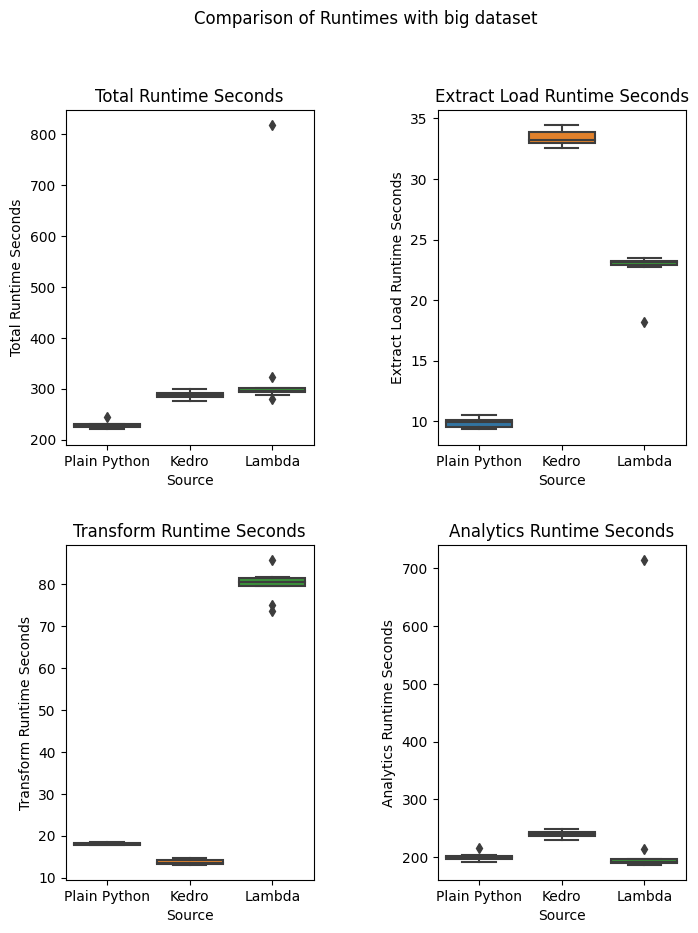

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

plain_python_big_data['Source'] = 'Plain Python'
kedro_big_data['Source'] = 'Kedro'
lambda_big_data['Source'] = 'Lambda'

combined_df = pd.concat([plain_python_big_data, kedro_big_data, lambda_big_data])
columns_to_plot = [
    'Total Runtime Seconds',
    'Extract Load Runtime Seconds',
    'Transform Runtime Seconds',
    'Analytics Runtime Seconds',
    ]


fig, axs = plt.subplots(2, 2, figsize=(8, 10))
plt.subplots_adjust(wspace=.5, hspace=.3)

for i, column in enumerate(columns_to_plot):
    # Determine subplot
    ax = axs[i//2, i%2]

    # Draw the boxplot on each subplot
    sns.boxplot(data=combined_df, x='Source', y=column, ax=ax, showfliers=False)

    # Set title for each subplot
    ax.set_title(column)

    
plt.suptitle("Comparison of Runtimes with big dataset")


plt.show()


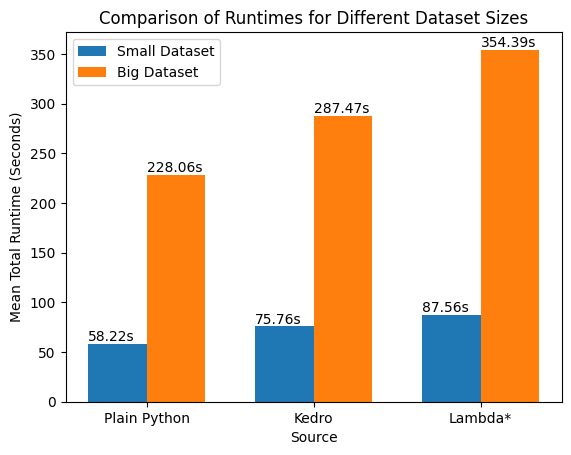

In [119]:
import numpy as np

# Create a dataset for the mean runtime for each source and dataset size
sources = ['Plain Python', 'Kedro', 'Lambda*']
means_small = [plain_python_data['Total Runtime Seconds'].mean(), kedro_data['Total Runtime Seconds'].mean(), lambda_data['Total Runtime Seconds'].mean()]
means_big = [plain_python_big_data['Total Runtime Seconds'].mean(), kedro_big_data['Total Runtime Seconds'].mean(), lambda_big_data['Total Runtime Seconds'].mean()]
sources = ['Plain Python', 'Kedro', 'Lambda*']
means_small = [plain_python_data['Total Runtime Seconds'].mean(), kedro_data['Total Runtime Seconds'].mean(), lambda_data['Total Runtime Seconds'].mean()]
means_big = [plain_python_big_data['Total Runtime Seconds'].mean(), kedro_big_data['Total Runtime Seconds'].mean(), lambda_big_data['Total Runtime Seconds'].mean()]

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(sources))
r2 = [x + bar_width for x in r1]

# Make the plot
fig, ax = plt.subplots()
bar1 = ax.bar(r1, means_small, width=bar_width, label='Small Dataset')
bar2 = ax.bar(r2, means_big, width=bar_width, label='Big Dataset')

for bar in ax.patches:
    yval = bar.get_height()
    ax.text(bar.get_x(), yval, f"{round(yval, 2)}s", va='bottom') # va: vertical alignment


# Add labels, legend, etc
ax.set_xlabel('Source')
ax.set_ylabel('Mean Total Runtime (Seconds)')
ax.set_title('Comparison of Runtimes for Different Dataset Sizes')
ax.set_xticks([r + bar_width/2 for r in range(len(sources))])
ax.set_xticklabels(sources)
ax.legend()

# Show the plot
plt.show()

In [118]:
# Calculate the percentage increase
percentage_increase = [(big - small) / small * 100 for small, big in zip(means_small, means_big)]

# Print the percentage increase for each source
for source, increase in zip(sources, percentage_increase):
    print(f"The percentage increase in runtime for {source} from the small to the big dataset is {increase:.2f}%")

The percentage increase in runtime for Plain Python from the small to the big dataset is 291.71%
The percentage increase in runtime for Kedro from the small to the big dataset is 279.46%
The percentage increase in runtime for Lambda* from the small to the big dataset is 304.73%


In [139]:
# Compute mean for each column in each dataset
plain_python_means = plain_python_data.iloc[:, -5:-1].mean().round(2)
kedro_means = kedro_data.iloc[:, -5:-1].mean().round(2)
lambda_means = lambda_data.iloc[:, -5:-1].mean().round(2)

# Create a new DataFrame to store the means
mean_data = pd.DataFrame({
    'Pipeline': ['Plain Python', 'Kedro', 'Lambda'],
    'Total Runtime Seconds': [plain_python_means['Total Runtime Seconds'], kedro_means['Total Runtime Seconds'], lambda_means['Total Runtime Seconds']],
    'Extract Load Runtime Seconds': [plain_python_means['Extract Load Runtime Seconds'], kedro_means['Extract Load Runtime Seconds'], lambda_means['Extract Load Runtime Seconds']],
    'Transform Runtime Seconds': [plain_python_means['Transform Runtime Seconds'], kedro_means['Transform Runtime Seconds'], lambda_means['Transform Runtime Seconds']],
    'Analytics Runtime Seconds': [plain_python_means['Analytics Runtime Seconds'], kedro_means['Analytics Runtime Seconds'], lambda_means['Analytics Runtime Seconds']],
})

mean_data

,Pipeline,Total Runtime Seconds,Extract Load Runtime Seconds,Transform Runtime Seconds,Analytics Runtime Seconds
0,Plain Python,58.22,6.19,3.28,48.74
1,Kedro,75.76,11.93,3.90,59.93
2,Lambda,87.56,11.22,19.74,56.60


In [140]:
# Compute mean for each column in each dataset
plain_python_big_means = plain_python_big_data.iloc[:, -5:-1].mean().round(2)
kedro_big_means = kedro_big_data.iloc[:, -5:-1].mean().round(2)
lambda_big_means = lambda_big_data.iloc[:, -5:-1].mean().round(2)

# Create a new DataFrame to store the means
mean_big_data = pd.DataFrame({
    'Pipeline': ['Plain Python', 'Kedro', 'Lambda'],
    'Total Runtime Seconds': [plain_python_big_means['Total Runtime Seconds'], kedro_big_means['Total Runtime Seconds'], lambda_big_means['Total Runtime Seconds']],
    'Extract Load Runtime Seconds': [plain_python_big_means['Extract Load Runtime Seconds'], kedro_big_means['Extract Load Runtime Seconds'], lambda_big_means['Extract Load Runtime Seconds']],
    'Transform Runtime Seconds': [plain_python_big_means['Transform Runtime Seconds'], kedro_big_means['Transform Runtime Seconds'], lambda_big_means['Transform Runtime Seconds']],
    'Analytics Runtime Seconds': [plain_python_big_means['Analytics Runtime Seconds'], kedro_big_means['Analytics Runtime Seconds'], lambda_big_means['Analytics Runtime Seconds']],
})

mean_big_data

,Pipeline,Total Runtime Seconds,Extract Load Runtime Seconds,Transform Runtime Seconds,Analytics Runtime Seconds
0,Plain Python,228.06,9.84,18.00,200.21
1,Kedro,287.47,33.41,13.74,240.32
2,Lambda,354.39,22.57,79.88,251.94


In [144]:
percentage_increase = (((mean_big_data.set_index('Pipeline') - mean_data.set_index('Pipeline')) / mean_data.set_index('Pipeline')) * 100).round(2)
percentage_increase.reset_index(inplace=True)

percentage_increase

,Pipeline,Total Runtime Seconds,Extract Load Runtime Seconds,Transform Runtime Seconds,Analytics Runtime Seconds
0,Plain Python,291.72,58.97,448.78,310.77
1,Kedro,279.45,180.05,252.31,301.00
2,Lambda,304.74,101.16,304.66,345.12
